In [4]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


# The Data

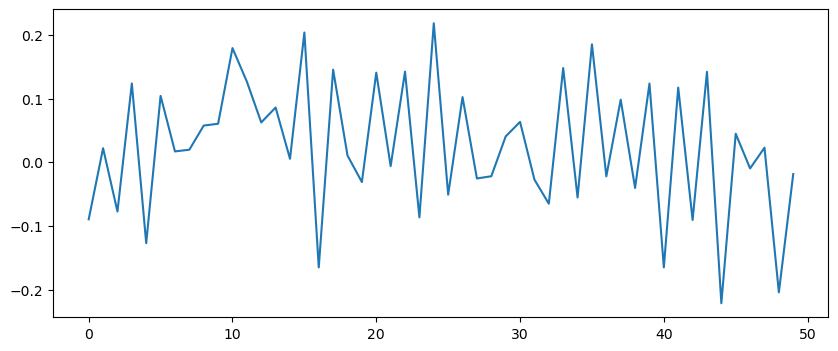

In [7]:
true_phi_1 = -0.2
true_phi_2 = 0.5
true_sigma = 0.1

xvals = [np.random.normal(0, true_sigma), np.random.normal(0, true_sigma)]
for _ in range(50):
    xvals.append(true_phi_1*xvals[-1] + true_phi_2*xvals[-2] + np.random.normal(0, true_sigma))
xvals = np.array(xvals[2:])
plt.figure(figsize=(10,4))
plt.plot(xvals)

# Usual Method : Fit AR Model

In [8]:
model = sm.tsa.arima.ARIMA(xvals, order=(2,0,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  52.828
Date:                Mon, 22 May 2023   AIC                            -97.657
Time:                        16:06:06   BIC                            -90.009
Sample:                             0   HQIC                           -94.744
                                 - 50                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0217      0.014      1.562      0.118      -0.006       0.049
ar.L1         -0.2830      0.133     -2.122      0.034      -0.544      -0.022
ar.L2          0.4107      0.168      2.439      0.015       0.081       0.741
sigma2         0.0070      0.002      4.162      0.000       0.004       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.68   Prob(JB):                         0.62
Heteroskedasticity (H):               1.22   Skew:                            -0.27
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

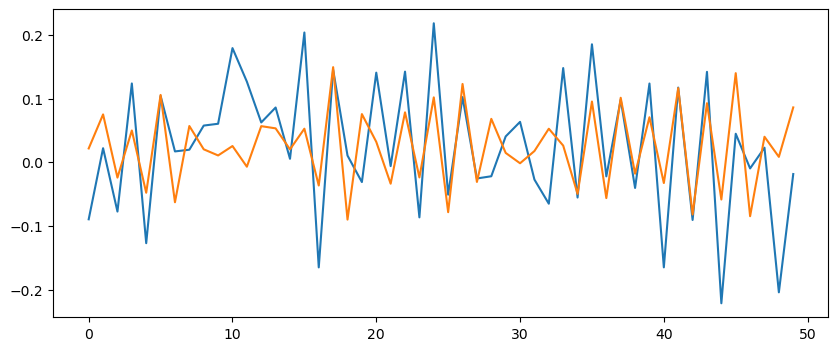

In [9]:
plt.figure(figsize=(10,4))
plt.plot(xvals)
plt.plot(model.fittedvalues)

In [31]:
forcastNew = model.get_prediction(0, 55)
forcastNew.conf_int([0.05])[50:55]

array([[-0.22356129,  0.10410347],
       [-0.14206267,  0.19847468],
       [-0.20191557,  0.17468921],
       [-0.15854777,  0.22722715],
       [-0.1944443 ,  0.20162647]])

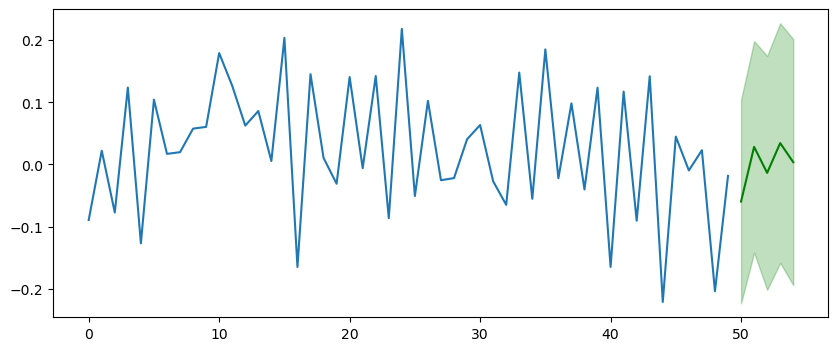

In [37]:
plt.figure(figsize=(10,4))
plt.plot(xvals)
forecast = model.forecast(5)

plt.plot(range(len(xvals), len(xvals) + 5), forecast, color='g')
plt.fill_between(range(len(xvals), len(xvals) + 5), forcastNew.conf_int([0.05])[50:55][:,0], forcastNew.conf_int([0.05])[50:55][:,1], color='g', alpha=0.25)

# Bayesian Analysis with PyMC3
***

# Priors:
## $\phi_1 \sim N(0,20)$
## $\phi_2 \sim N(0,20)$
## $\sigma \sim Exp(1)$
***

# Likelihood:
## $x_t|\phi_1, \phi_2, \sigma, x_{t-1}, x_{t-2} \sim N(\phi_1 x_{t-1} + \phi_2 x_{t-2}, \sigma)$
***

# Posterior
## $\phi_1, \phi_2, \sigma|x \sim ?$
***

C:\Users\fridm\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, phi]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
C:\Users\fridm\anaconda3\lib\site-packages\arviz\utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\911109068.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fridm\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarnin

<Figure size 700x700 with 0 Axes>

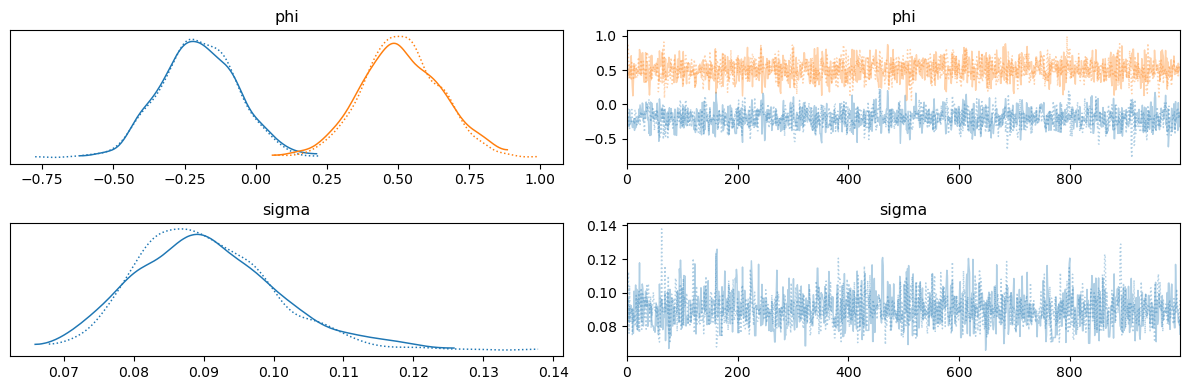

In [39]:
with pm.Model() as bayes_model:
    #priors
    phi = pm.Normal("phi", mu=0, sigma=20, shape=2)
    sigma = pm.Exponential("sigma", lam=1)

    #Likelihood
    likelihood = pm.AR("x", phi, sigma, observed=xvals)

    #posterior
    trace = pm.sample(1000, cores=2)
    
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

# Parameter Distributions

C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\1404322737.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(phi1_vals)


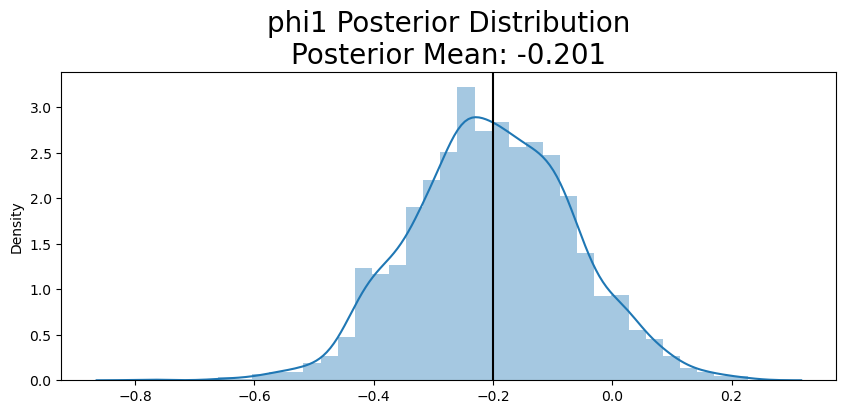

C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\1404322737.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(phi2_vals)


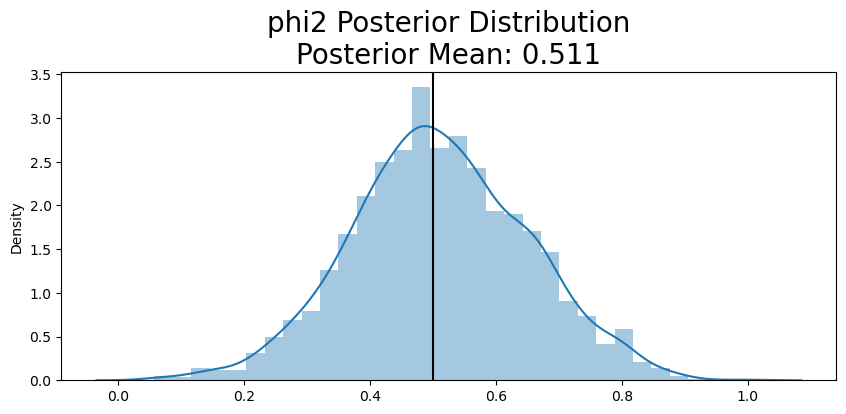

C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\1404322737.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sigma_vals)


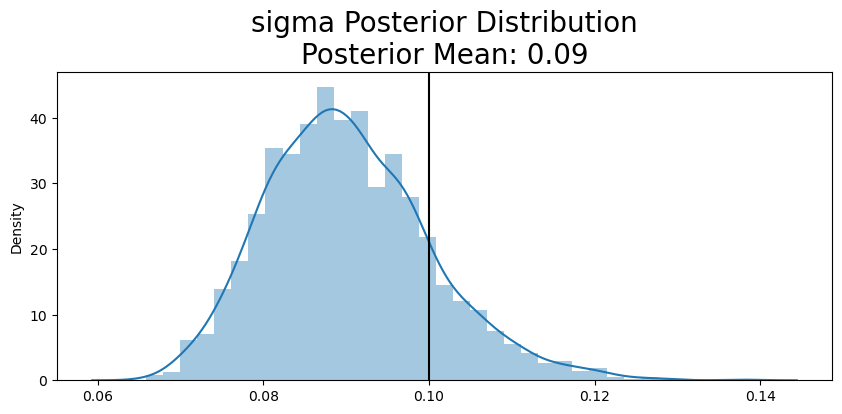

In [40]:
phi1_vals = trace.get_values('phi')[:,0]
phi2_vals = trace.get_values('phi')[:,1]
sigma_vals = trace.get_values('sigma')

plt.figure(figsize=(10,4))
sns.distplot(phi1_vals)
plt.axvline(true_phi_1, color='k')
plt.title('phi1 Posterior Distribution\nPosterior Mean: %s'%round(phi1_vals.mean(), 3), fontsize=20)
plt.show()

plt.figure(figsize=(10,4))
sns.distplot(phi2_vals)
plt.axvline(true_phi_2, color='k')
plt.title('phi2 Posterior Distribution\nPosterior Mean: %s'%round(phi2_vals.mean(), 3), fontsize=20)
plt.show()

plt.figure(figsize=(10,4))
sns.distplot(sigma_vals)
plt.axvline(true_sigma, color='k')
plt.title('sigma Posterior Distribution\nPosterior Mean: %s'%round(sigma_vals.mean(), 3), fontsize=20)
plt.show()

# Forecast Next Values

In [41]:
num_samples = 10000
forecasted_vals = []
num_periods = 5

for _ in range(num_samples):
    curr_vals = list(xvals.copy())
    
    phi1_val = np.random.choice(phi1_vals)
    phi2_val = np.random.choice(phi2_vals)
    sigma_val = np.random.choice(sigma_vals)
    
    for _ in range(num_periods):
        curr_vals.append(curr_vals[-1]*phi1_val + curr_vals[-2]*phi2_val + np.random.normal(0, sigma_val))
    forecasted_vals.append(curr_vals[-num_periods:]) 
forecasted_vals = np.array(forecasted_vals)

C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\2950386913.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vals)


IndexError: invalid index to scalar variable.

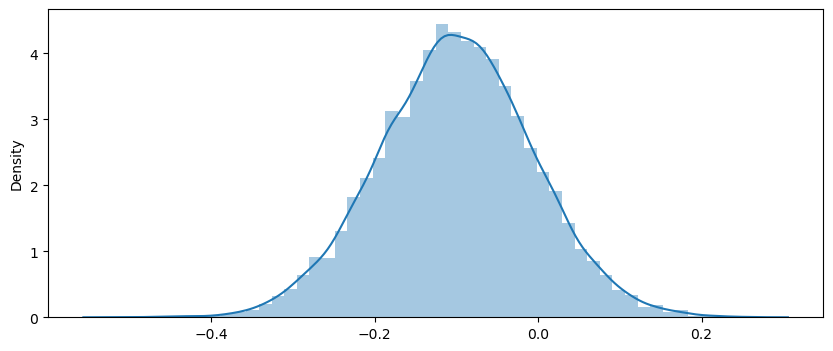

In [42]:
for i in range(num_periods):
    plt.figure(figsize=(10,4))
    vals = forecasted_vals[:,i]
    mu, dev = round(vals.mean(), 3), round(vals.std(), 3)
    sns.distplot(vals)
    p1 = plt.axvline(forecast[0][i], color='k')
    p2 = plt.axvline(vals.mean(), color='b')
    plt.legend((p1,p2), ('MLE', 'Posterior Mean'), fontsize=20)
    plt.title('Forecasted t+%s\nPosterior Mean: %s\nMLE: %s\nSD Bayes: %s\nSD MLE: %s'%((i+1), mu, round(forecast[0][i],3), dev, round(forecast[1][i],3)), fontsize=20)